In [1]:
import sys
sys.path.append('D:\\python\\Lib\\site-packages')

In [4]:
import cv2
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import coo_matrix
from scipy.sparse import diags
import matplotlib.pyplot as plt
import time
import math

In [3]:
# input x should be a column or row
# the output of P(x, mask_data) has the same data structure as x
def P(x, mask_data):
    md = (mask_data.ravel()).astype(np.int) # ravel是用来将矩阵向量化的操作
    omega = np.array(np.where(md == 1))[0,:]
    return x[omega]

def A(x, mask_data):
    x1 = cv2.idct(x)
    x1 = np.reshape(x1, (65536, ))
    Ax = P(x1, mask_data)
    return Ax.ravel()

# base on Hunber-function definition
def sum_of_huber(x, delta):
    sum_hub = 0
    for z in x:
        if abs(z) <= delta:
            hub_z = 1 / (2 * delta) * (z **2)
        else:
            hub_z = abs(z) - 0.5 * delta
        sum_hub += hub_z
    return sum_hub

# objective function
def f(x, b, mask_data, miu, delta):
    f1 = np.linalg.norm(A(x, mask_data)-b)** 2 / 2
    f2 = miu * sum_of_huber(x, delta)
    fx = 0.5*(np.linalg.norm(f1)) + f2 
    return fx


In [4]:
def ATA(x, mask_data):
    md = mask_data.ravel()
    x1 = cv2.idct(x)
    idct_x = np.reshape(x1, (65536, )) 
    ata = cv2.dct(md * idct_x)
    ata_x = np.reshape(ata, (65536, )) 
    return ata_x

# gradient of Hunber-function
def hunber_grad(x, delta):
    
    for z in x:
        if abs(z) < delta:
            z = z / delta
        else:
            if z >= 0:
                z = 1
            else:
                z = -1
    return x

# gradient of objective function
def g(x, mask_data, damage, miu, delta):
    g1 = ATA(x, mask_data)
    g2 = cv2.dct(damage)
    g2 = np.reshape(g2, (65536, ))
    g3 = hunber_grad(x, delta)
    gx = g1 - g2+ miu * g3
    return gx

In [5]:
def TwoLoopRecursion(g, y_list, s_list, rho_list, m):
    q = g
    a = np.zeros(len(s_list))
    #print("a", a)
    for i in range(len(s_list), 0, -1):
        a[i-1] = np.dot(np.dot(rho_list[i-1],s_list[i-1].T),q)
        q -= np.dot(a[i-1],y_list[i-1])
    up_H = np.dot(s_list[len(s_list)-1].T, y_list[len(y_list)-1])
    down_H = np.linalg.norm(y_list[len(y_list)-1])** 2
    r = (up_H / down_H )* scipy.sparse.diags(np.array([1]*len(q))).dot(q)
    for i in range(0, len(s_list)):
        beta = np.dot(np.dot(rho_list[i] , y_list[i].T), r)
        r += np.dot((a[i]-beta),s_list[i])
    return -r

In [28]:
def L_BFGS(x0, H0, image_data, mask_data, memory_size, miu_data, delta_data):
    
    # step 1: Initial point x0 and parameter
    m = memory_size # memory size with [5, 7, 10, 12]
    miu = miu_data #0.001 # for Hunber-function [0.001, 0.1]
    delta = delta_data #0.01 # for Hunber-function [0.01, 0.5]
    
    sigma = 0.5
    gamma = 0.1
    tolerance = 1e-13 # epsilon
    max_k = 1000 # maximum iteration    

    # Use for two loop recursion
    rho_list = []
    s_list = []
    y_list = []    
    
    # Use for Ax-b
    b = P(image_data.ravel(), mask_data)
    
    # Use for A.T * b
    damage = (image_data * mask_data).ravel()
    
    x_k_1, x_k = x0, x0
    g_k_1, g_k = g(x_k_1, mask_data, damage, miu, delta), g(x_k, mask_data, damage, miu, delta)
    H = H0
    
    # for convergence use
    x_norm = []
    i_record = []
    
    # step 2: compute the quasi-Newton direction
    d = - H.dot(g_k)
    print("k, f(xk), ||g(x_k+1)||, alpha")
    
    for k in range(max_k):
        alpha = 1 # step size
        # step 3: calculate a step size alpha using backtracking
        # Amijo line search find step size alpha        
        account = 0
        f_k = f(x_k, b, mask_data, miu, delta)
        f_k_1 = f(x_k_1, b, mask_data, miu, delta)
        g_k = g(x_k, mask_data, damage, miu, delta)
        g_k_1 = g(x_k_1, mask_data, damage, miu, delta)
        g_d = np.dot(g_k.T, d)
        while (f_k_1 - f_k) > - gamma * alpha * (g_d ** 2) and account <= 10:
            alpha = sigma * alpha
            account += 1
            x_k_1 = x_k_1 + alpha * d
            f_k_1 = f(x_k_1, b, mask_data, miu, delta)

        x_norm.append(np.linalg.norm(x_k_1))
        i_record.append(k)

        # step 4: set x_k+1 = x_k + alpha * d_k
        g_k = g(x_k, mask_data, damage, miu, delta)
        g_k_1 = g(x_k_1, mask_data, damage, miu, delta)
        
        # if gradient(x_k+1) <= tolerance, stop and x_k+1 is the output
        stop_tag = np.linalg.norm(g_k_1)
        print(k, f_k_1, stop_tag, alpha)
        if stop_tag <= tolerance:
            break 
 
        
        # step 5: set s_k and y_k. 
        s = x_k_1 - x_k
        y = g_k_1 - g_k
        s_y = (s.T).dot(y)
        
        # ensure memory size limit to m
        # pair{s, y} should be added to the current curvature pairs 
        #if the condition s*y > 1e-14
        if s_y > 1e-14:
            if len(y_list) < m:
                y_list.append(y)
                s_list.append(s) 
                rho_list.append(1/s_y)
            else:
                y_list.append(y)
                s_list.append(s) 
                rho_list.append(1/s_y)
                y_list.pop(0)
                s_list.pop(0)
                rho_list.pop(0)
        
        # applying two-loop recursion algorithm to compute H
        # and updated quasi-Newton direction
        if len(s_list) != 0:
            d = TwoLoopRecursion(g(x_k_1, mask_data, damage, miu, delta), y_list, s_list, rho_list, m)
        
        x_k = x_k_1

    return x_k_1, x_norm, i_record

In [25]:
def PSNR(y, u):
    m = y.shape[0]
    n = y.shape[1]
    a = m * n
    b = np.linalg.norm(y - u)
    psnr = 10 * math.log(a / b)
    return psnr
    

In [51]:
def result_image_data(x, image):
    x1 = cv2.idct(x)
    x2 = x1 * 255
    x3 = x2.reshape(image.shape[0], image.shape[1])
    return x3

In [29]:
# 载入灰度图：原始
test_image = cv2.imread('C:/Users/YU/Desktop/6106/test_images/512_512_lena.png', cv2.IMREAD_GRAYSCALE)
# 对图像进行处理
# 缩小图像的一半
test_image = cv2.resize(test_image,(256, 256))
# 原始图像与256比值
test_image = test_image / 255

In [30]:
x0 = np.zeros((test_image.shape[0],test_image.shape[1])).ravel()
data = [0.5]*65536
row = np.arange(0,256*256)
H = coo_matrix((data, (row, row)), shape=(65536,65536))
H0 = H
#H0 = scipy.sparse.diags(np.array([0]*len(x0)))
#H0 = np.eye(len(x0))

In [31]:
image_norm = np.linalg.norm(test_image)
image_norm

133.42898990827706

In [32]:
# 载入灰度图：mask
test_mask1 = cv2.imread('C:/Users/YU/Desktop/6106/test_masks/512_512_handwriting.png', cv2.IMREAD_GRAYSCALE)
test_mask2 = cv2.imread('C:/Users/YU/Desktop/6106/test_masks/512_512_mesh.png', cv2.IMREAD_GRAYSCALE)
test_mask3 = cv2.imread('C:/Users/YU/Desktop/6106/test_masks/512_512_random50.png', cv2.IMREAD_GRAYSCALE)
test_mask4 = cv2.imread('C:/Users/YU/Desktop/6106/test_masks/512_512_scratches_01.png', cv2.IMREAD_GRAYSCALE)
# 对图像进行处理
# 缩小图像的一半
test_mask1 = cv2.resize(test_mask1,(256, 256))
test_mask2 = cv2.resize(test_mask2,(256, 256))
test_mask3 = cv2.resize(test_mask3,(256, 256))
test_mask4 = cv2.resize(test_mask4,(256, 256))
# binary mask Ind
Ind1 = (test_mask1 != 0)
Ind2 = (test_mask2 != 0)
Ind3 = (test_mask3 != 0)
Ind4 = (test_mask4 != 0)

In [47]:
memory_size = [5, 7, 10, 12]
miu_value = [0.001, 0.01, 0.1]
delta_value = [0.01, 0.1, 0.5]

In [49]:
m_data = dict()
for m in memory_size:
    for mu in miu_value:
        for dla in delta_value:
            start = time.time()
            result_x, x_norm, iteration = L_BFGS(x0, H0, test_image, Ind1, m, mu, dla)
            end = time.time()
            CPU_T = end - start
            m_data[m, mu, dla] = [result_x, x_norm, iteration, CPU_T]


k, f(xk), ||g(x_k+1)||, alpha
0 1007.1608585602614 63.282770505442585 0.00048828125
1 8.268572935361183 0.03089979028579882 0.00048828125
2 8.268464763962317 0.01544989514289667 0.5
3 8.268455345067348 0.007724947571439352 0.5
4 8.268475686834416 3.771947073511003e-06 0.00048828125
5 8.268475704033445 1.8417811872302188e-09 0.00048828125
6 8.268475704041842 9.07037932128978e-13 0.00048828125
7 8.26847570404184 4.338362595026714e-13 0.5
8 8.268475704041848 6.168078266634897e-14 0.00048828125
k, f(xk), ||g(x_k+1)||, alpha
0 1005.3328520162996 63.282770505442585 0.00048828125
1 5.928631258325058 0.03089979028579882 0.00048828125
2 5.92845344477591 0.01544989514289667 0.5
3 5.928409210640982 0.007724947571439352 0.5
4 5.928398261733367 0.003862473785745239 0.5
5 5.928395579319387 0.0019312368928440795 0.5
6 5.9283949361224195 0.0009656184464676301 0.5
7 5.928394789026271 0.0004828092232240584 0.5
8 5.928394759103862 0.00024140461161682277 0.5
9 5.928394755049189 0.0001207023057988625 0.5
1

29 230.61862467839524 1.0372980942663307e-10 0.5
30 230.618624678264 5.1846912313843583e-11 0.5
31 230.6186246781994 2.5914923185947855e-11 0.5
32 230.6186246781678 1.2974842139942423e-11 0.5
33 230.61862467815126 6.4838531032236346e-12 0.5
34 230.61862467814302 3.2463859749320003e-12 0.5
35 230.61862467813916 1.6268827957738699e-12 0.5
36 230.6186246781374 8.048803736086319e-13 0.5
37 230.61862467813643 4.1393049144829837e-13 0.5
38 230.61862467813563 2.0311227068858397e-13 0.5
39 230.61862467813543 9.151761907704973e-14 0.5
k, f(xk), ||g(x_k+1)||, alpha
0 1007.1608585602614 63.282770505442585 0.00048828125
1 8.268572935361183 0.03089979028579882 0.00048828125
2 8.268464763962317 0.01544989514289667 0.5
3 8.268455345067348 0.007724947571439352 0.5
4 8.268475686834416 3.771947073511003e-06 0.00048828125
5 8.268475704033445 1.8417811872302188e-09 0.00048828125
6 8.268475704041842 9.07037932128978e-13 0.00048828125
7 8.26847570404184 4.338362595026714e-13 0.5
8 8.268475704041848 6.168078

18 230.61862521642448 2.1240722705802436e-07 0.5
19 230.61862494727947 1.0620364426075749e-07 0.5
20 230.61862481270373 5.310178880702167e-08 0.5
21 230.61862474541573 2.6550890208203116e-08 0.5
22 230.6186247117754 1.327542841522603e-08 0.5
23 230.61862469495327 6.6377321345051165e-09 0.5
24 230.6186246865438 3.3188704596698678e-09 0.5
25 230.61862468233485 1.6594266120283556e-09 0.5
26 230.6186246802356 8.297174866727526e-10 0.5
27 230.61862467918607 4.148771484010712e-10 0.5
28 230.61862467865984 2.0744226928515262e-10 0.5
29 230.61862467839524 1.0372980942663307e-10 0.5
30 230.618624678264 5.1846912313843583e-11 0.5
31 230.6186246781994 2.5914923185947855e-11 0.5
32 230.6186246781678 1.2974842139942423e-11 0.5
33 230.61862467815126 6.4838531032236346e-12 0.5
34 230.61862467814302 3.2463859749320003e-12 0.5
35 230.61862467813916 1.6268827957738699e-12 0.5
36 230.6186246781374 8.048803736086319e-13 0.5
37 230.61862467813643 4.1393049144829837e-13 0.5
38 230.61862467813563 2.031122706

7 230.6197271413717 0.0004350100126328904 0.5
8 230.6191758996182 0.00021750500632711052 0.5
9 230.61890028634195 0.00010875250316064667 0.5
10 230.61876248160053 5.4376251575736035e-05 0.5
11 230.61869357970804 2.718812579115873e-05 0.5
12 230.6186591288793 1.3594062891698423e-05 0.5
13 230.61864190349837 6.797031450062508e-06 0.5
14 230.6186332908116 3.3985157213592215e-06 0.5
15 230.61862898446873 1.6992578445537888e-06 0.5
16 230.6186268313 8.496289260082247e-07 0.5
17 230.6186257547167 4.248144593444062e-07 0.5
18 230.61862521642448 2.1240722705802436e-07 0.5
19 230.61862494727947 1.0620364426075749e-07 0.5
20 230.61862481270373 5.310178880702167e-08 0.5
21 230.61862474541573 2.6550890208203116e-08 0.5
22 230.6186247117754 1.327542841522603e-08 0.5
23 230.61862469495327 6.6377321345051165e-09 0.5
24 230.6186246865438 3.3188704596698678e-09 0.5
25 230.61862468233485 1.6594266120283556e-09 0.5
26 230.6186246802356 8.297174866727526e-10 0.5
27 230.61862467918607 4.148771484010712e-10

3 553.9555627833126 6.637749746437597e-09 0.00048828125
4 553.9555627862719 3.2205126579277663e-12 0.00048828125
5 553.9555627862738 5.100157765542566e-14 0.00048828125
k, f(xk), ||g(x_k+1)||, alpha
0 1073.183496243336 57.01763237513612 0.00048828125
1 230.68934579173052 0.02784064080818033 0.00048828125
2 230.6539437197415 0.01392032040408141 0.5
3 230.6362738201357 0.006960160202058168 0.5
4 230.62744665443654 0.003480080101000205 0.5
5 230.62303501761022 0.001740040050559707 0.5
6 230.62082968569825 0.0008700200252250562 0.5
7 230.6197271413717 0.0004350100126328904 0.5
8 230.6191758996182 0.00021750500632711052 0.5
9 230.61890028634195 0.00010875250316064667 0.5
10 230.61876248160053 5.4376251575736035e-05 0.5
11 230.61869357970804 2.718812579115873e-05 0.5
12 230.6186591288793 1.3594062891698423e-05 0.5
13 230.61864190349837 6.797031450062508e-06 0.5
14 230.6186332908116 3.3985157213592215e-06 0.5
15 230.61862898446873 1.6992578445537888e-06 0.5
16 230.6186268313 8.496289260082247

In [53]:
psnr = dict()
for m in memory_size:
    for mu in miu_value:
        for dla in delta_value:
            data_x = m_data[m, mu, dla][0]
            psnr[m, mu, dla] = PSNR(test_image, result_image_data(data_x, test_image))
            

In [54]:
psnr

{(5, 0.001, 0.01): 7.127515571008097,
 (5, 0.001, 0.1): 7.127515571008091,
 (5, 0.001, 0.5): 7.127515571008098,
 (5, 0.01, 0.01): 7.2173780593104855,
 (5, 0.01, 0.1): 7.217378059310481,
 (5, 0.01, 0.5): 7.217378059310487,
 (5, 0.1, 0.01): 8.074518993157177,
 (5, 0.1, 0.1): 8.074518993157177,
 (5, 0.1, 0.5): 8.07451899315718,
 (7, 0.001, 0.01): 7.127515571008097,
 (7, 0.001, 0.1): 7.127515571008091,
 (7, 0.001, 0.5): 7.127515571008098,
 (7, 0.01, 0.01): 7.2173780593104855,
 (7, 0.01, 0.1): 7.217378059310481,
 (7, 0.01, 0.5): 7.217378059310487,
 (7, 0.1, 0.01): 8.074518993157177,
 (7, 0.1, 0.1): 8.074518993157177,
 (7, 0.1, 0.5): 8.07451899315718,
 (10, 0.001, 0.01): 7.127515571008097,
 (10, 0.001, 0.1): 7.127515571008091,
 (10, 0.001, 0.5): 7.127515571008098,
 (10, 0.01, 0.01): 7.2173780593104855,
 (10, 0.01, 0.1): 7.217378059310481,
 (10, 0.01, 0.5): 7.217378059310487,
 (10, 0.1, 0.01): 8.074518993157177,
 (10, 0.1, 0.1): 8.074518993157177,
 (10, 0.1, 0.5): 8.07451899315718,
 (12, 0.00

In [59]:
time_iteration = dict()
psnr = dict()
for m in memory_size:
    for mu in miu_value:
        for dla in delta_value:
            time_iteration[m, mu, dla] = [m_data[m, mu, dla][3], len(m_data[m, mu, dla][2])]

In [60]:
time_iteration

{(5, 0.001, 0.01): [5.1392621994018555, 9],
 (5, 0.001, 0.1): [6.603349208831787, 13],
 (5, 0.001, 0.5): [14.498246431350708, 41],
 (5, 0.01, 0.01): [4.309480667114258, 6],
 (5, 0.01, 0.1): [6.131610155105591, 10],
 (5, 0.01, 0.5): [14.465334177017212, 41],
 (5, 0.1, 0.01): [4.307485818862915, 6],
 (5, 0.1, 0.1): [5.006617307662964, 6],
 (5, 0.1, 0.5): [14.236944675445557, 40],
 (7, 0.001, 0.01): [5.2130656242370605, 9],
 (7, 0.001, 0.1): [6.701087713241577, 13],
 (7, 0.001, 0.5): [14.508219718933105, 41],
 (7, 0.01, 0.01): [4.236675977706909, 6],
 (7, 0.01, 0.1): [6.104681491851807, 10],
 (7, 0.01, 0.5): [14.365600824356079, 41],
 (7, 0.1, 0.01): [4.222712755203247, 6],
 (7, 0.1, 0.1): [4.922842264175415, 6],
 (7, 0.1, 0.5): [14.169125080108643, 40],
 (10, 0.001, 0.01): [5.167187929153442, 9],
 (10, 0.001, 0.1): [6.515583753585815, 13],
 (10, 0.001, 0.5): [14.455361366271973, 41],
 (10, 0.01, 0.01): [4.245650768280029, 6],
 (10, 0.01, 0.1): [6.180479526519775, 10],
 (10, 0.01, 0.5): [

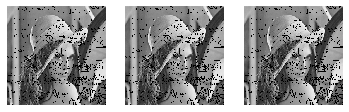

In [70]:
# compare at m = 5 and miu = 0.01
plt.figure(0.01)
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.01, 0.01)][0], test_image), 'gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.01, 0.1)][0], test_image), 'gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.01, 0.5)][0], test_image), 'gray')

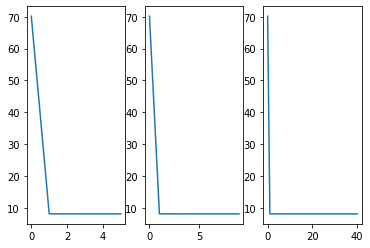

In [73]:
# compare at m = 5 and miu = 0.01
plt.figure(0.01)
plt.subplot(1,3,1)
plt.plot(m_data[(5, 0.01, 0.01)][2], image_norm - m_data[(5, 0.01, 0.01)][1])
plt.subplot(1,3,2)
plt.plot(m_data[(5, 0.01, 0.1)][2], image_norm - m_data[(5, 0.01, 0.1)][1])
plt.subplot(1,3,3)
plt.plot(m_data[(5, 0.01, 0.5)][2], image_norm - m_data[(5, 0.01, 0.5)][1])

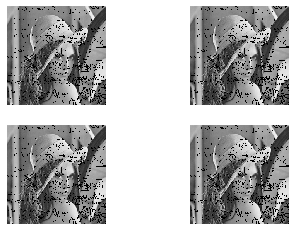

In [72]:
# compare at miu = 0.01 and delta = 0.5
plt.figure(0.01)
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.01, 0.5)][0], test_image), 'gray')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(result_image_data(m_data[(7, 0.01, 0.5)][0], test_image), 'gray')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(result_image_data(m_data[(10, 0.01, 0.5)][0], test_image), 'gray')
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(result_image_data(m_data[(12, 0.01, 0.5)][0], test_image), 'gray')

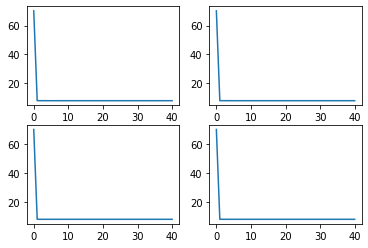

In [74]:
# compare at miu = 0.01 and delta = 0.5
plt.figure(0.01)
plt.subplot(2,2,1)
plt.plot(m_data[(5, 0.01, 0.5)][2], image_norm - m_data[(5, 0.01, 0.5)][1])
plt.subplot(2,2,2)
plt.plot(m_data[(7, 0.01, 0.5)][2], image_norm - m_data[(7, 0.01, 0.5)][1])
plt.subplot(2,2,3)
plt.plot(m_data[(10, 0.01, 0.5)][2], image_norm - m_data[(10, 0.01, 0.5)][1])
plt.subplot(2,2,4)
plt.plot(m_data[(12, 0.01, 0.5)][2], image_norm - m_data[(12, 0.01, 0.5)][1])

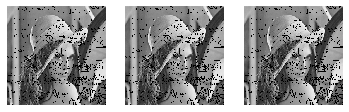

In [75]:
# compare at m = 5 and delta = 0.01
plt.figure(0.01)
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.001, 0.01)][0], test_image), 'gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.01, 0.01)][0], test_image), 'gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(result_image_data(m_data[(5, 0.1, 0.01)][0], test_image), 'gray')

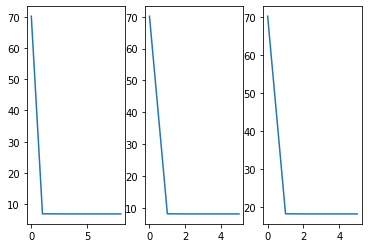

In [76]:
# compare at m = 5 and delta = 0.01
plt.figure(0.01)
plt.subplot(1,3,1)
plt.plot(m_data[(5, 0.001, 0.01)][2], image_norm - m_data[(5, 0.001, 0.01)][1])
plt.subplot(1,3,2)
plt.plot(m_data[(5, 0.01, 0.01)][2], image_norm - m_data[(5, 0.01, 0.01)][1])
plt.subplot(1,3,3)
plt.plot(m_data[(5, 0.1, 0.01)][2], image_norm - m_data[(5, 0.1, 0.01)][1])

In [40]:
aaa = dict()

In [41]:
aaa[1,2,3] = 4

In [43]:
aaa[3,2,4] = [31, 24, [22, 4]]

In [46]:
aaa[3,2,4]

[31, 24, [22, 4]]

In [44]:
aaa

{(1, 2, 3): 4, (3, 2, 4): [31, 24, [22, 4]]}

In [12]:
test1, test_norm1, i1 = L_BFGS(x0, H0, test_image, Ind1, )

k, f(xk), ||g(x_k+1)||, alpha
0 1007.1608585602614 63.282770505442585 0.00048828125
1 8.268572935361183 0.03089979028579882 0.00048828125
2 8.268464763962317 0.01544989514289667 0.5
3 8.268455345067348 0.007724947571439352 0.5
4 8.268475686834416 3.771947073511003e-06 0.00048828125
5 8.268475704033445 1.8417811872302188e-09 0.00048828125
6 8.268475704041842 9.07037932128978e-13 0.00048828125
7 8.26847570404184 4.338362595026714e-13 0.5
8 8.268475704041848 6.168078266634897e-14 0.00048828125


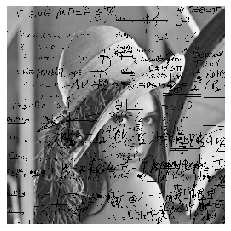

In [20]:
tidct1 = cv2.idct(test1)
tidct_1 = tidct1 * 255
tt1 = tidct_1.reshape(test_image.shape[0], test_image.shape[1])
plt.axis('off')
plt.imshow(tt1, 'gray')
plt.savefig('t1.png')

Text(0, 0.5, 'convergence')

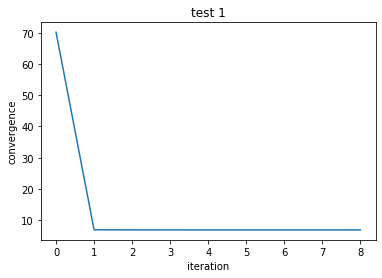

In [16]:
plt.plot(i1, image_norm - test_norm1)
plt.title('test 1')
plt.xlabel('iteration')
plt.ylabel('convergence')

In [17]:
psnr1 = PSNR(test_image, tt1)
psnr1

7.127515571008097

In [ ]:
test2, test_norm2 = L_BFGS(x0, H0, test_image, Ind2)

In [ ]:
tidct2 = cv2.idct(test2)
tidct_2 = tidct2 * 255
tt2 = tidct_2.reshape(test_image.shape[0], test_image.shape[1])
plt.axis('off')
plt.imshow(tt2, 'gray')

In [ ]:
ite2 = []
for i in range(len(test_norm2)):
    ite2.append(i)
plt.plot(ite2, image_norm - test_norm2)
plt.title('test 2')
plt.xlabel('iteration')
plt.ylabel('convergence')

In [ ]:
test3, test_norm3 = L_BFGS(x0, H0, test_image, Ind3)

In [ ]:
tidct3 = cv2.idct(test3)
tidct_3 = tidct1 * 255
tt3 = tidct_3.reshape(test_image.shape[0], test_image.shape[1])
plt.axis('off')
plt.imshow(tt3, 'gray')

In [ ]:
ite3 = []
for i in range(len(test_norm3)):
    ite3.append(i)
plt.plot(ite3, image_norm - test_norm3)
plt.title('test 3')
plt.xlabel('iteration')
plt.ylabel('convergence')

In [ ]:
test4, test_norm4 = L_BFGS(x0, H0, test_image, Ind4)

In [ ]:
tidct4 = cv2.idct(test4)
tidct_4 = tidct4 * 255
tt4 = tidct_4.reshape(test_image.shape[0], test_image.shape[1])
plt.axis('off')
plt.imshow(tt4, 'gray')

In [ ]:
ite4 = []
for i in range(len(test_norm4)):
    ite4.append(i)
plt.plot(ite4, image_norm - test_norm4)
plt.title('test 4')
plt.xlabel('iteration')
plt.ylabel('convergence')

In [ ]:
psnr1 = PSNR(test_image, tt1)
psnr2 = PSNR(test_image, tt2)
psnr3 = PSNR(test_image, tt3)
psnr4 = PSNR(test_image, tt4)

In [ ]:
psnr1, psnr2, psnr3, psnr4